In [1]:
# Sentiment Analysis Prediction
# Loads pre-trained models and predicts sentiment for cleaned reviews

import pandas as pd
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
import warnings

In [2]:
# Load pre-trained models and vectorizer
# These models were trained in the previous notebook
print("Loading models...")
with open("../models/feature-bow.p", "rb") as f:
    vectorizer = pickle.load(f)

with open("../models/model-nb.p", "rb") as f:
    model_nb = pickle.load(f)

with open("../models/model-nn.p", "rb") as f:
    model_nn = pickle.load(f)

print("Models loaded successfully")

Loading models...
Models loaded successfully


d:\My Stuff\Kuliah\Semester 5\Web App\data-crawling\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\My Stuff\Kuliah\Semester 5\Web App\data-crawling\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2.post1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\My Stuff\Kuliah\Semester 5\Web App\data-crawling\venv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying

In [3]:
# Load cleaned review data
df = pd.read_csv("../outputs/cleaned_reviews.csv")
print(df.head())

                                              review  \
0  Laptop tergolong ringan,tidak terlalu besar......   
1  pengiriman cepat, spek barang sesuai, packing ...   
2        manntab respon cepet barang ok dan original   
3  Barang cepat sampai dan sesuai informasi, Admi...   
4  spek sesuai deskripsi, pengiriman gercep, sell...   

                                      cleaned_review  
0  laptop tergolong ringan tidak terlalu besar ma...  
1   pengiriman cepat spek barang sesuai packing aman  
2        manntab respon cepet barang ok dan original  
3  barang cepat sampai dan sesuai informasi admin...  
4  spek sesuai deskripsi pengiriman gercep seller...  


In [4]:
def predict_sentiments(df, text_column):
    """
    Predict sentiment using ensemble of Naive Bayes and Neural Network models.
    Uses dynamic weighting based on model confidence.
    """
    print("Making predictions...")
    
    # Transform text data using pre-trained vectorizer
    X = vectorizer.transform(df['cleaned_review'])

    # Get prediction probabilities from both models
    proba_nb = model_nb.predict_proba(X)
    proba_nn = model_nn.predict_proba(X)

    # Dynamic ensemble weighting based on confidence
    # More confident model gets higher weight
    nb_confidence = np.max(proba_nb, axis=1)
    nn_confidence = np.max(proba_nn, axis=1)
    
    # Calculate dynamic weights
    total_confidence = nb_confidence + nn_confidence
    weight_nb = nb_confidence / total_confidence
    weight_nn = nn_confidence / total_confidence
    
    # Combine probabilities using dynamic weights
    combined_proba = np.zeros_like(proba_nb)
    for i in range(len(proba_nb)):
        combined_proba[i] = (weight_nb[i] * proba_nb[i]) + (weight_nn[i] * proba_nn[i])

    # Get final predictions and confidence scores
    classes = model_nb.classes_
    final_preds = [classes[np.argmax(p)] for p in combined_proba]
    final_confidence = np.max(combined_proba, axis=1)

    # Store all predictions
    df['sentiment_nb'] = model_nb.predict(X)
    df['sentiment_nn'] = model_nn.predict(X)
    df['sentiment_final'] = final_preds
    df['confidence'] = final_confidence
    
    print(f"Predictions completed")
    print(f"Average confidence: {np.mean(final_confidence):.3f}")
    
    return df

In [5]:
# Run sentiment prediction
df = predict_sentiments(df, 'cleaned_review')

# Display prediction summary
print("\nPREDICTION SUMMARY")
print("=" * 40)
print("Final sentiment distribution:")
print(df['sentiment_final'].value_counts())
print(f"\nConfidence range: {df['confidence'].min():.3f} - {df['confidence'].max():.3f}")
print(f"Low confidence predictions (<0.7): {(df['confidence'] < 0.7).sum()}")
print()

print("Sample predictions:")
print(df[['cleaned_review', 'sentiment_final', 'confidence']].head())

Making predictions...
Predictions completed
Average confidence: 0.693

PREDICTION SUMMARY
Final sentiment distribution:
sentiment_final
positive    42
neutral     26
negative    23
Name: count, dtype: int64

Confidence range: 0.438 - 1.000
Low confidence predictions (<0.7): 51

Sample predictions:
                                      cleaned_review sentiment_final  \
0  laptop tergolong ringan tidak terlalu besar ma...        positive   
1   pengiriman cepat spek barang sesuai packing aman        positive   
2        manntab respon cepet barang ok dan original         neutral   
3  barang cepat sampai dan sesuai informasi admin...        negative   
4  spek sesuai deskripsi pengiriman gercep seller...        negative   

   confidence  
0    0.680371  
1    0.667202  
2    0.649360  
3    0.609240  
4    0.723230  


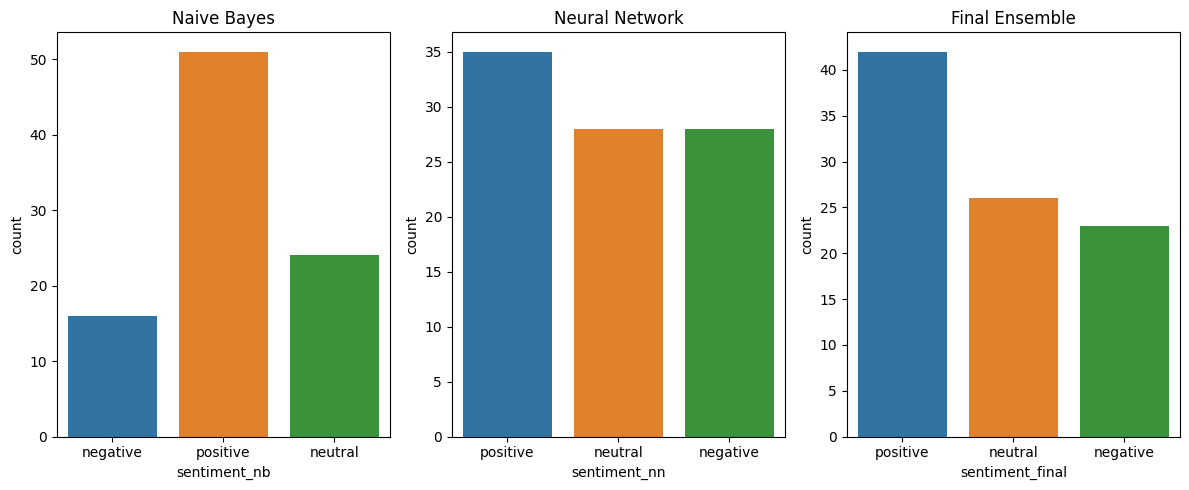

In [6]:
# Compare sentiment distributions across models
plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.countplot(x='sentiment_nb', data=df, hue='sentiment_nb', legend=False)
plt.title("Naive Bayes")

plt.subplot(1, 3, 2)
sns.countplot(x='sentiment_nn', data=df, hue='sentiment_nn', legend=False)
plt.title("Neural Network")

plt.subplot(1, 3, 3)
sns.countplot(x='sentiment_final', data=df, hue='sentiment_final', legend=False)
plt.title("Final Ensemble")

plt.tight_layout()
plt.show()

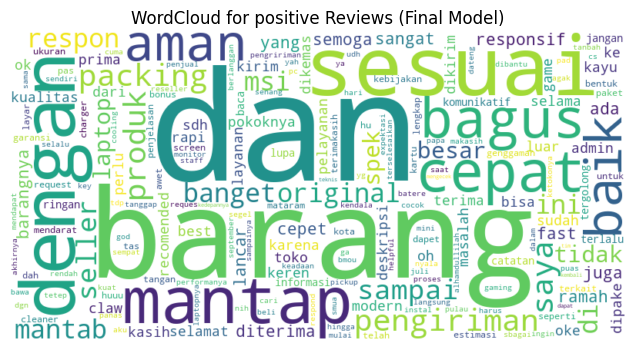

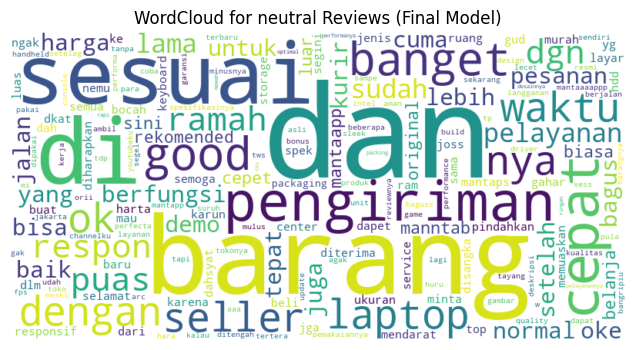

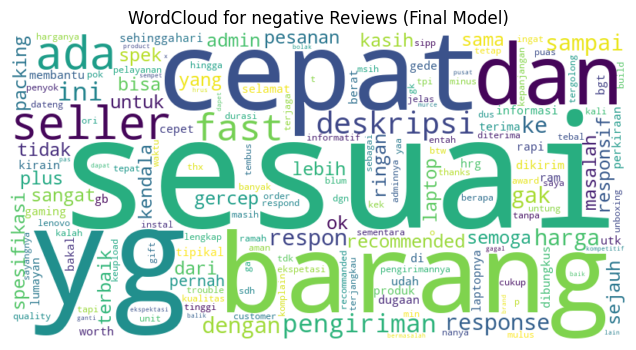

In [7]:
# Generate word clouds for each sentiment class
for sentiment in df['sentiment_final'].unique():
    text = " ".join(df[df['sentiment_final'] == sentiment]['cleaned_review'])
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Reviews (Final Model)")
    plt.show()

LOW CONFIDENCE PREDICTIONS (for manual review):
Confidence: 0.438 | negative | sesuai...
Confidence: 0.444 | positive | performanya bagus layanan penjual juga cepat tanggap...
Confidence: 0.462 | positive | respon admin cepat dan pengiriman lancar barang juga bagus recomended seller...
Confidence: 0.462 | neutral | joss...
Confidence: 0.462 | neutral | mantaaaappp...



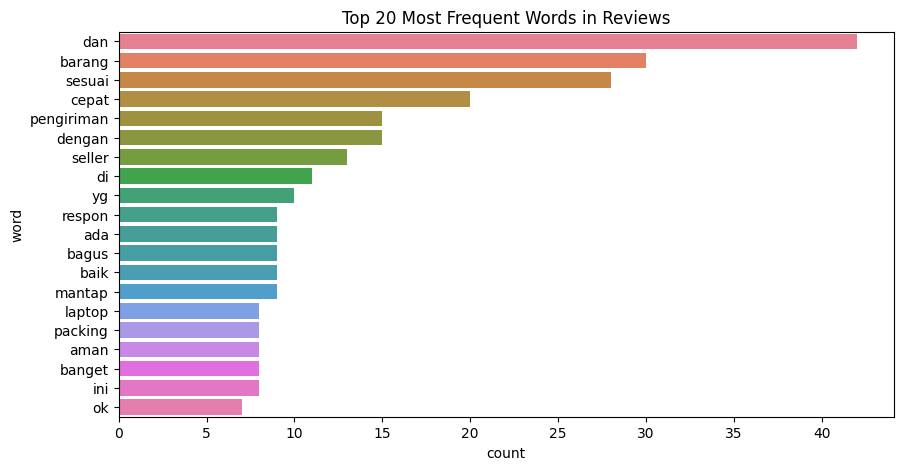

In [8]:
from collections import Counter
import re

# Identify low confidence predictions for manual review
print("LOW CONFIDENCE PREDICTIONS (for manual review):")
print("=" * 50)
low_conf = df[df['confidence'] < 0.7].sort_values('confidence')
if len(low_conf) > 0:
    for idx, row in low_conf.head(5).iterrows():
        print(f"Confidence: {row['confidence']:.3f} | {row['sentiment_final']} | {row['cleaned_review'][:80]}...")
else:
    print("All predictions have high confidence!")

print()

# Analyze most frequent words across all reviews
all_text = " ".join(df['cleaned_review'])
words = re.findall(r'\w+', all_text)
freq = Counter(words)

top_words = pd.DataFrame(freq.most_common(20), columns=['word', 'count'])

plt.figure(figsize=(10,5))
sns.barplot(y='word', x='count', data=top_words, hue='word', legend=False)
plt.title("Top 20 Most Frequent Words in Reviews")
plt.show()

In [9]:
# Save predictions with confidence scores
df.to_csv("../outputs/tokopedia_sentiments.csv", index=False)
print("Predictions saved to ../outputs/tokopedia_sentiments.csv")
print(f"Total predictions: {len(df)}")
print(f"Average confidence: {df['confidence'].mean():.3f}")
print(f"High confidence (>0.8): {(df['confidence'] > 0.8).sum()}")

Predictions saved to ../outputs/tokopedia_sentiments.csv
Total predictions: 91
Average confidence: 0.693
High confidence (>0.8): 25
